# Обнаружение мошеннических транзакций

Целевой признак - Class. 1 - мошенническая транзакция, 0 - нормальная.

**Файл с данными: "Fraud_data_transaction.csv"**
https://drive.google.com/file/d/1ZwZIZrsZzxYjSv_pO3bTqxTzhmYI6Xs8/view?usp=sharing

**Цели работы:**

1. Поскольку данные несбалансированы (вы должны проиллюстрировать это), то нужно создать таблицу данных с распределением 50/50 для «мошеннических» и «немошеннических» транзакций. (Алгоритм NearMiss)
2. Определить с каким классификатором будет более высокая точность предсказаний. 
3. Создать нейронную сеть и сравнить точность с нашим лучшим классификатором.


**План:**
1. Прочитать данные, создать датафрейм.

2. Предварительная обработка: 
a) Масштабирование и распределение; 
b) Разделение данных.

3. Простое повторное использование данных (Random oversampling) и уменьшение количества данные в более представленных классах (Undersampling):
a) Распределение и корреляция;
b) Обнаружение аномалий;
c) Снижение размерности и кластеризация (t-SNE);
d) Классификаторы;
e) Более глубокий взгляд на логистическую регрессию;
f) Генерация синтетических данных с SMOTE;

4. Оценка модели логистической регрессии на тестовом наборе.

**Важно!** Данные несбалансированны. Большинство транзакций были немошенническими (99,83%). Покажите это.

Если использовать эти данные без предварительной обработки в качестве основы для прогностических моделей и анализа, можно получить много ошибок, связанные с переобучением.

## Датафрейм

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
df = pd.read_csv('Fraud_data_transaction.csv')

In [111]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [70]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [71]:
df.isnull().sum().max()

np.int64(0)

In [72]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Покажите, что данные несбалансированы.

In [73]:
print('Мошеннических транзакций', df[df['Class'] == 1].shape[0])
print('Не мошеннических транзакций', df[df['Class'] == 0].shape[0])
print(f'Доля не мошеннических транзакций {(1 - df[df['Class'] == 1].shape[0] / df[df['Class'] == 0].shape[0]) * 100:.2f}%')

Мошеннических транзакций 492
Не мошеннических транзакций 284315
Доля не мошеннических транзакций 99.83%


## Масштабирование и распределение
На этом этапе нужно масштабировать столбцы Time и Amount. 
Также необходимо создать подвыборку фрейма данных, чтобы иметь равное количество случаев мошенничества и немошенничества, что поможет алгоритмам лучше понять закономерности, которые определяют, является ли транзакция мошенничеством или нет.

**Что такое подвыборка?**
В этом сценарии наша подвыборка будет фреймом данных с соотношением мошеннических и немошеннических транзакций 50/50. Это означает, что ваша подвыборка будет иметь одинаковое количество мошеннических и немошеннических транзакций.

/tmp/ipykernel_9402/3028048997.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(amount_val, ax=ax[0], color='r')
/tmp/ipykernel_9402/3028048997.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_val, ax=ax[1], color='b')


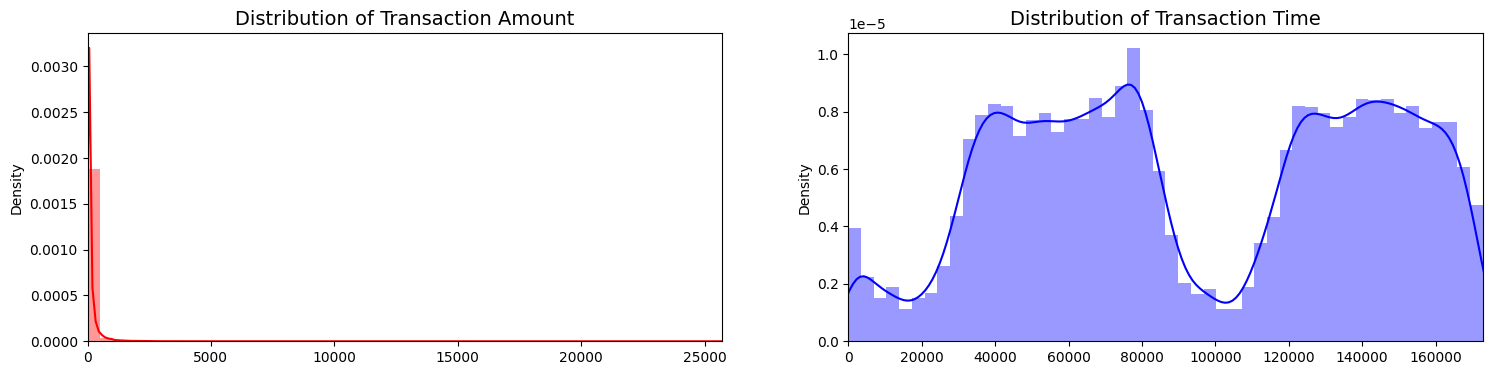

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [121]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [122]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.350151,1.641931
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.254117,1.641952
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.081839,1.641974
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.313249,1.641974


In [123]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Разделение данных


In [129]:
y = df['Class']
X = df.drop(['Class'], axis=1)

In [131]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=None, shuffle =False)

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

NameError: name 'StratifiedKFold' is not defined

In [ ]:
original_Xtrain = original_Xtrain.values
original_Xtest = ...
original_ytrain = ...
original_ytest = ...

Покажите, что обучающие и тестовые данные распределены одинаково.

In [ ]:
train_unique_label, train_counts_label = np.unique(...)
test_unique_label, test_counts_label = ...

print('Label Distributions: \n')
print(...)

## Простое повторное использование данных  (Random Under-Sampling):

На этом этапе необходимо реализовать случайную недостаточную выборку, которая заключается в удалении данных для получения более сбалансированного набора данных и, таким образом, избежания переобучения моделей.



Поскольку наши классы сильно перекошены, мы должны сделать их эквивалентными, чтобы иметь нормальное распределение классов. 
Перемешайте данные перед созданием подвыборок

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = ...

normal_distributed_df = pd.concat(...)

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

##  Равномерное распределение и корреляция: 

Теперь, когда данные сбалансированы, можно продолжить анализ и предварительную обработку данных.

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

**Постройте матрицу корреляций для датафрейма df.**

Сделайте выводы о том, каким образом признаки могут влиять на целевую переменную. 


In [ ]:
...

## Выявление аномалий
Главная цель в этом разделе — удалить «экстремальные выбросы» из признаков, которые имеют высокую корреляцию с нашими классами. Это окажет положительное влияние на точность наших моделей.

### Метод межквартильного размаха:

Мы вычисляем его по разнице между 75-м процентилем и 25-м процентилем. Наша цель — создать порог за пределами 75-го и 25-го процентиля, чтобы в случае, если какой-либо экземпляр превысит этот порог, экземпляр был удален.
Помимо того, что легко увидеть 25-й и 75-й процентили (оба конца квадратов), также легко увидеть экстремальные выбросы (точки за пределами нижнего и верхнего экстремума).

### Компромисс удаления выбросов:

Мы должны быть осторожны с тем, насколько далеко мы хотим установить порог для удаления выбросов. Мы определяем порог, умножая число (например, 1,5) на (межквартильном размахе). Чем выше этот порог, тем меньше выбросов будет обнаружено (умножение на большее число, например, 3), и чем ниже этот порог, тем больше выбросов будет обнаружено.

**Компромисс:** Чем ниже порог, тем больше выбросов он удалит, однако мы хотим больше сосредоточиться на «экстремальных выбросах», а не просто на выбросах.  Вы можете поиграть с этим порогом и посмотреть, как он влияет на точность наших моделей классификации.

### Резюме:

**Визуализация распределений:** Сначала мы начнем с визуализации распределения признака, который мы собираемся использовать для устранения некоторых выбросов. V14 — единственный признак, который имеет гауссово распределение по сравнению с признаками V12 и V10.

**Определение порога:** После того, как мы решим, какое число мы будем использовать для умножения на iqr (чем ниже, тем больше выбросов удаляется), мы продолжим определение верхнего и нижнего порогов, подставляя q25 - порог (нижний экстремальный порог) и добавляя q75 + порог (верхний экстремальный порог).

**Условное отбрасывание:** Наконец, мы создаем условное отбрасывание, утверждая, что если «порог» превышен в обоих крайних значениях, то экземпляры будут удалены.

Представление в виде коробчатой диаграммы: визуализируйте с помощью коробчатой диаграммы, что количество «экстремальных выбросов» было значительно сокращено.

### Примечание:
после внедрения сокращения выбросов наша точность была улучшена более чем на 3%! Некоторые выбросы могут исказить точность наших моделей, но помните, что мы должны избегать экстремальной потери информации, иначе наша модель рискует оказаться недообученной.


In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [ ]:
# # -----> V14 Удаление выбросов (наивысшая отрицательная корреляция с метками)

v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 удаление выбросов из мошеннических транзакций
v12_fraud = ...
q25, q75 = ...
v12_iqr = ...

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Удаление выбросов V10
v10_fraud = ...
q25, q75 = ...
v10_iqr = ...

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Boxplots с удаленными выбросами

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
...

# Feature V10
...


plt.show()

## Снижение размерности и кластеризация. t-SNE


Можете посмотреть видео <a href="https://www.youtube.com/watch?v=NEaUSP4YerM"> StatQuest: t-SNE, Clearly Explained </a> Joshua Starmer

Алгоритм **t-SNE** может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных.
Хотя подвыборка довольно мала, алгоритм **t-SNE** способен довольно точно обнаруживать кластеры в каждом сценарии.
Это дает нам указание на то, что дальнейшие прогностические модели будут работать довольно хорошо при разделении случаев мошенничества и не мошенничества.

In [ ]:
X = new_df.drop('Class', axis=1)
y = ...


t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
...

# TruncatedSVD scatter plot
...

plt.show()

## Классификаторы UnderSampling (недостаточная выборка):


В этом разделе необходимо обучить четыре типа классификаторов и решить какой классификатор будет более эффективен в обнаружении мошеннических транзакций. 


1. Классификатор логистической регрессии в большинстве случаев точнее, чем три других классификатора. 
2. GridSearchCV используется для определения параметров, которые дают наилучшую прогностическую оценку для классификаторов.
3. Логистическая регрессия имеет наилучшую оценку рабочей характеристики приема (ROC), что означает, что LogisticRegression довольно точно разделяет мошеннические и не мошеннические транзакции.


Чем больше разрыв между оценкой обучения и оценкой перекрестной проверки, тем больше вероятность того, что ваша модель переобучается (высокая дисперсия).
Если оценка низкая как в обучающем наборе, так и в наборе для перекрестной проверки, это указывает на то, что  модель недостаточно обучена (высокое смещение)
Логистический регрессионный классификатор показывает лучшую оценку как в обучающем наборе, так и в наборе для перекрестной проверки.

In [ ]:
# Недостаточная выборка перед перекрестной проверкой (склонна к переобучению)
X = new_df.drop('Class', axis=1)
y = ...

Данные уже масштабированы, их следует разделить на обучающие и тестовые наборы

In [ ]:
X_train, X_test, y_train, y_test = ...

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Простые классификаторы

In [ ]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

Реализуем перекрестную валидацию

In [ ]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Используйте GridSearchCV для поиска наилучших параметров.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Классификатор опорных векторов
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# Деревья решений
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [ ]:
# Случай переобучения

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = ...
print('Knears Neighbors Cross Validation Score',...)

svc_score = ...
print(...)

tree_score = ...
print(...)

**Undersample** с перекрестной проверкой

In [ ]:
undersample_X = df.drop('Class', axis=1)
undersample_y = ...

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = ...
undersample_ytrain = ...
undersample_ytest = ...

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

Реализация метода **NearMiss**

In [ ]:
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))


for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    ...

Plot LogisticRegression Learning Curve

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    ...
    
    # Third Estimator
    ...
    
    # Fourth Estimator
    ...
    
    return plt

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

Создайте DataFrame со всеми оценками и именами классификаторов.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict


log_reg_pred = ...

knears_pred = ...

svc_pred = ...

tree_pred = ...

In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
...
...
...
...

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## Более детальный взгляд на логистическую регрессию

In [ ]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = ...

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = ...

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)


print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

In [ ]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [ ]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(...)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

**Напишите выводы:**

### Метод SMOTE Over-Sampling (избыточная выборка):

В отличие от случайной недостаточной выборки, SMOTE создает новые синтетические точки для достижения равного баланса классов. Это еще один вариант решения «проблем дисбаланса классов».

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))


accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []


log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

 ### Реализация техники SMOTE

In [ ]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(...), rand_log_reg)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(...)
    precision_lst.append(...)
    recall_lst.append(...)
    f1_lst.append(...)
    auc_lst.append(...)
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

In [ ]:
y_score = ...

In [ ]:
average_precision = ...

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

# Тестовые данные с логистической регрессией:

In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = ...

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

Для всех предсказаний постройте матрицу спутааности (confusion_matrix)

In [ ]:
...

In [ ]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

И "classification_report"

In [ ]:
from sklearn.metrics import classification_report

...

Итоговая оценка логистической регрессии для тестового набора

In [ ]:
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
...

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
...

**Сделайте выводы**